<a href="https://colab.research.google.com/github/arahogc/Whats_In_A_Bottle/blob/Jess/winemag_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Winemag-data_first150K Data Preprocessing

### **Overview**

**Purpose:** To preprocess the winemag data so that it can be run through a machine learning model to predict price and/or rating (points). 

**Cleaning To-Do list:**
1. Check the null values in each column
2. Drop columns with large number of null values (>50% null)
3. For columns with null values that we want to keep for model training, fill the na values with something
4. Remove rows with null values that we're okay with excluding
5. Bin data in columns with more than X unique values -> Need to think about this more because there are a few columns that have a significant number of unique values with a count of 1
6. Tokenize the description column
7. Remove Stop words from the tokenized description
8. Count the number of tokens and add a new column to the df
9. Encode the filtered description tokens
10. Encode the remaining columns after cleaned and binned
11. Export the dataframe as a csv file and store in database


### **Import Dependencies and Initialize the Spark Session**

In [1]:
# Initialize Spark
import os

# Find the latest version of spark 2.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
#spark_version = 'spark-2.4.5'
spark_version = 'spark-3.0.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Ign:13 https://developer.download.nvidia.com/compute/c

In [2]:
# Install Spark NLP
! pip install --ignore-installed spark-nlp==2.4.5

! pip install pyspark

# Install nltk
! pip install nltk

     |████████████████████████████████| 112kB 5.5MB/s 
     |████████████████████████████████| 212.3MB 68kB/s 
     |████████████████████████████████| 204kB 46.7MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=e881ea5247ff4c3475418ed5483612c63693be2bb2ecf68e2f7330dbabf67712
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [3]:
# Import spark nlp
import sparknlp
spark = sparknlp.start()

In [79]:
# Import dependencies
import pandas as pd 

from pyspark import SparkFiles
from pyspark.sql import SparkSession

from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

# Import the stop words library
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover, Normalizer, StringIndexer

# Import sklearn and tensorflow dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf

In [5]:
# Start Spark session with connection to postgres
spark = SparkSession.builder.appName("Whats_In_A_Bottle").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

## Data Cleaning:

### **Check the null values in each column and drop columns with large number of null values (>50% null)**

In [5]:
# Read in data from S3 Buckets
url ="https://whats-in-a-bottle.s3-us-west-1.amazonaws.com/winemag-data_first150k.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("winemag-data_first150k.csv"), sep=",", header=True)
df.show()

+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+-----------------+------------------+--------------------+
|_c0|country|         description|         designation|points|price|          province|            region_1|         region_2|           variety|              winery|
+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+-----------------+------------------+--------------------+
|  0|     US|This tremendous 1...|   Martha's Vineyard|    96|235.0|        California|         Napa Valley|             Napa|Cabernet Sauvignon|               Heitz|
|  1|  Spain|Ripe aromas of fi...|Carodorum Selecci...|    96|110.0|    Northern Spain|                Toro|             null|     Tinta de Toro|Bodega Carmen Rod...|
|  2|     US|Mac Watson honors...|Special Selected ...|    96| 90.0|        California|      Knights Valley|           Sonoma|   Sauvignon Blanc|            Macauley

In [6]:
# Get count of both null and missing values in pyspark
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+-------+-----------+-----------+------+-----+--------+--------+--------+-------+------+
|_c0|country|description|designation|points|price|province|region_1|region_2|variety|winery|
+---+-------+-----------+-----------+------+-----+--------+--------+--------+-------+------+
|  0|      5|          1|      45733|     6|13697|      11|   25059|   89963|      6|    17|
+---+-------+-----------+-----------+------+-----+--------+--------+--------+-------+------+



In [7]:
# Drop the region_2 column
df = df.drop("region_2")
df.show()

+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+
|_c0|country|         description|         designation|points|price|          province|            region_1|           variety|              winery|
+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+
|  0|     US|This tremendous 1...|   Martha's Vineyard|    96|235.0|        California|         Napa Valley|Cabernet Sauvignon|               Heitz|
|  1|  Spain|Ripe aromas of fi...|Carodorum Selecci...|    96|110.0|    Northern Spain|                Toro|     Tinta de Toro|Bodega Carmen Rod...|
|  2|     US|Mac Watson honors...|Special Selected ...|    96| 90.0|        California|      Knights Valley|   Sauvignon Blanc|            Macauley|
|  3|     US|This spent 20 mon...|             Reserve|    96| 65.0|            Oregon|   Willamette Valle

### **Fill null values for columns we want to keep with N/A, then drop remaining rows with null values**

In [8]:
#Count the region unique values
region_df = df.groupby(df.region_1).count().distinct()
region_df.orderBy(col('count').desc()).show()

+--------------------+-----+
|            region_1|count|
+--------------------+-----+
|                null|25059|
|         Napa Valley| 6205|
|Columbia Valley (WA)| 4975|
|             Mendoza| 3586|
|Russian River Valley| 3571|
|          California| 3460|
|         Paso Robles| 3053|
|   Willamette Valley| 2096|
|               Rioja| 1893|
|             Toscana| 1885|
|       Sonoma County| 1852|
|Brunello di Monta...| 1746|
|             Sicilia| 1701|
|              Alsace| 1574|
|        Sonoma Coast| 1473|
|            Carneros| 1458|
|    Dry Creek Valley| 1398|
|              Barolo| 1397|
|        Finger Lakes| 1372|
|           Champagne| 1369|
+--------------------+-----+
only showing top 20 rows



In [9]:
# Replace null values in the region_1 and designation columns with "other" since we'll keep these columns
# consider dropping designation column if it becomes an issue later
replaced_df = df.na.fill({"region_1": "N/A", "designation":"N/A"})
replaced_df.show()

+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+
|_c0|country|         description|         designation|points|price|          province|            region_1|           variety|              winery|
+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+
|  0|     US|This tremendous 1...|   Martha's Vineyard|    96|235.0|        California|         Napa Valley|Cabernet Sauvignon|               Heitz|
|  1|  Spain|Ripe aromas of fi...|Carodorum Selecci...|    96|110.0|    Northern Spain|                Toro|     Tinta de Toro|Bodega Carmen Rod...|
|  2|     US|Mac Watson honors...|Special Selected ...|    96| 90.0|        California|      Knights Valley|   Sauvignon Blanc|            Macauley|
|  3|     US|This spent 20 mon...|             Reserve|    96| 65.0|            Oregon|   Willamette Valle

In [10]:
# Check to see if the region null values have been replaced with "N/A"
replaced_region_counts = replaced_df.groupby(replaced_df.region_1).count().distinct().orderBy(col('count').desc())
replaced_region_counts.show()

+--------------------+-----+
|            region_1|count|
+--------------------+-----+
|                 N/A|25059|
|         Napa Valley| 6205|
|Columbia Valley (WA)| 4975|
|             Mendoza| 3586|
|Russian River Valley| 3571|
|          California| 3460|
|         Paso Robles| 3053|
|   Willamette Valley| 2096|
|               Rioja| 1893|
|             Toscana| 1885|
|       Sonoma County| 1852|
|Brunello di Monta...| 1746|
|             Sicilia| 1701|
|              Alsace| 1574|
|        Sonoma Coast| 1473|
|            Carneros| 1458|
|    Dry Creek Valley| 1398|
|              Barolo| 1397|
|        Finger Lakes| 1372|
|           Champagne| 1369|
+--------------------+-----+
only showing top 20 rows



In [12]:
# Check to see if the designation null values have been replaced with "N/A"
replaced_designation_counts = replaced_df.groupby(replaced_df.designation).count().distinct().orderBy(col('count').desc())
replaced_designation_counts.show()

+--------------------+-----+
|         designation|count|
+--------------------+-----+
|                 N/A|45733|
|             Reserve| 2752|
|             Reserva| 1810|
|              Estate| 1571|
|       Barrel sample| 1326|
|             Riserva|  754|
|       Barrel Sample|  639|
|                Brut|  624|
|             Crianza|  503|
|        Estate Grown|  449|
|      Estate Bottled|  396|
|                 Dry|  374|
|        Gran Reserva|  330|
|            Old Vine|  330|
|           Brut Rosé|  248|
|           Extra Dry|  244|
|     Vieilles Vignes|  225|
|Bien Nacido Vineyard|  195|
|                Rosé|  180|
|Late Bottled Vintage|  171|
+--------------------+-----+
only showing top 20 rows



In [14]:
# Drop rows with null values
dropna_df = replaced_df.na.drop()

# Check that the null values have been removed
dropna_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dropna_df.columns]).show()

+---+-------+-----------+-----------+------+-----+--------+--------+-------+------+
|_c0|country|description|designation|points|price|province|region_1|variety|winery|
+---+-------+-----------+-----------+------+-----+--------+--------+-------+------+
|  0|      0|          0|          0|     0|    0|       0|       0|      0|     0|
+---+-------+-----------+-----------+------+-----+--------+--------+-------+------+



### **NLP - Tokenize, Remove Stop Words, and Hash the [Description] column**

In [15]:
# Create a function to return the length of a list
def word_list_length(word_list):
  return len(word_list)

In [16]:
# Create a user defined function
count_tokens = udf(word_list_length, IntegerType())

In [17]:
# Tokenize sentences
tokenizer = Tokenizer(inputCol="description", outputCol="words")
tokenizer

Tokenizer_b752aaf06147

In [18]:
# Create our Tokenizer
tokenizer = Tokenizer(inputCol="description", outputCol="words")

# Transform DataFrame
tokenized_df = tokenizer.transform(dropna_df)

# Select the needed column and don't truncate results
tokenized_df = tokenized_df.withColumn("tokens", count_tokens(col("words")))
tokenized_df.show(truncate=False)

+---+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+------+-----+------------------+-------------------------+------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [19]:
# Normalize tokens? Lemmatize (get root word) and/or remove accents from words?

In [20]:
# Use the word remover
# Run the remover
remover = StopWordsRemover(inputCol="words",outputCol="filtered")
# Tranform and show data
removed_df = remover.transform(tokenized_df)
removed_df.show(truncate=False)

+---+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+------+-----+------------------+-------------------------+------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
# Select the needed column and don't truncate results
filtered_tokens_df = removed_df.withColumn("filtered_tokens", count_tokens(col("filtered")))
filtered_tokens_df.show(truncate=False)

+---+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+------+-----+------------------+-------------------------+------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [22]:
! pip install nltk

In [23]:
# Run the hashing term frequency
hashing = HashingTF(inputCol="filtered", outputCol="hashedValues", numFeatures=pow(2,18))

# Transform into a DF
hashed_df = hashing.transform(filtered_tokens_df)
hashed_df.show(truncate=False)

+---+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+------+-----+------------------+-------------------------+------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [120]:
# Fit the IDF on the data set
idf = IDF(inputCol="hashedValues", outputCol="features")
idfModel = idf.fit(hashed_df)
rescaledData = idfModel.transform(hashed_df)

# Display the DataFrame
rescaledData.show(truncate=True)

+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+--------------------+------+--------------------+---------------+--------------------+--------------------+
|_c0|country|         description|         designation|points|price|          province|            region_1|           variety|              winery|               words|tokens|            filtered|filtered_tokens|        hashedValues|            features|
+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+--------------------+------+--------------------+---------------+--------------------+--------------------+
|  0|     US|This tremendous 1...|   Martha's Vineyard|    96|235.0|        California|         Napa Valley|Cabernet Sauvignon|               Heitz|[this, tremendous...|    60|[tremendous, 100%...|             36|(262144,[2701,160..

In [119]:
rescaledData.dtypes

[('_c0', 'string'),
 ('country', 'string'),
 ('description', 'string'),
 ('designation', 'string'),
 ('points', 'string'),
 ('price', 'string'),
 ('province', 'string'),
 ('region_1', 'string'),
 ('variety', 'string'),
 ('winery', 'string'),
 ('words', 'array<string>'),
 ('tokens', 'int'),
 ('filtered', 'array<string>'),
 ('filtered_tokens', 'int'),
 ('hashedValues', 'vector'),
 ('features', 'vector')]

### **Bin column values for encoding**

In [107]:
# Convert Spark df to Pandas df
rescaledData_pd = rescaledData.toPandas()

In [109]:
# Drop the _C0 column because its an identifier, and the description column because it's already encoded (as well as words, filtered, and hashedValues)
rescaledData_pd = rescaledData_pd.drop(['_c0','description','words','filtered','hashedValues'], axis=1)
rescaledData_pd.head(5)

,country,designation,points,price,province,region_1,variety,winery,tokens,filtered_tokens,features
0,US,Martha's Vineyard,96,235.0,California,Napa Valley,Cabernet Sauvignon,Heitz,60,36,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Spain,Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,Tinta de Toro,Bodega Carmen Rodríguez,51,31,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,US,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sauvignon Blanc,Macauley,47,30,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,US,Reserve,96,65.0,Oregon,Willamette Valley,Pinot Noir,Ponzi,62,43,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,France,La Brûlade,95,66.0,Provence,Bandol,Provence red blend,Domaine de la Bégude,66,37,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [110]:
# Look at the country value counts for binning
country_counts = rescaledData_pd.country.value_counts()
country_counts

US                         62135
Italy                      18781
France                     14783
Spain                       8160
Chile                       5766
Argentina                   5587
Australia                   4891
Portugal                    4176
New Zealand                 3073
Austria                     2483
Germany                     2347
South Africa                2237
Greece                       872
Israel                       610
Hungary                      230
Canada                       194
Romania                      139
Uruguay                       85
Croatia                       83
Slovenia                      81
Bulgaria                      77
Moldova                       71
Mexico                        63
Turkey                        50
Georgia                       43
Lebanon                       37
Cyprus                        31
Brazil                        25
Macedonia                     16
Serbia                        14
Morocco   

In [111]:
# Replace country values for binning

# Determine which values to replace if counts are less than X
replace_country = list(country_counts[country_counts < 1000].index)

# Replace in dataframe
for i in replace_country:
  rescaledData_pd.country = rescaledData_pd.country.replace(i, "Other")

# Check to make sure binning was successful
rescaledData_pd.country.value_counts()

US              62135
Italy           18781
France          14783
Spain            8160
Chile            5766
Argentina        5587
Australia        4891
Portugal         4176
New Zealand      3073
Other            2803
Austria          2483
Germany          2347
South Africa     2237
Name: country, dtype: int64

In [122]:
# Look at the designation value counts for binning
designation_counts = rescaledData_pd.designation.value_counts()
designation_counts.tail(100)

Other                   82648
N/A                     42304
Reserve                  2704
Reserva                  1755
Estate                   1561
Riserva                   607
Brut                      556
Crianza                   494
Estate Grown              448
Estate Bottled            395
Dry                       364
Old Vine                  330
Gran Reserva              319
Brut Rosé                 227
Bien Nacido Vineyard      195
Extra Dry                 194
Vieilles Vignes           177
Rosé                      171
Late Harvest              161
Unoaked                   156
Barrel Select             145
Grand Reserve             138
Single Vineyard           137
Réserve                   137
Old Vines                 127
Estate Reserve            121
Late Bottled Vintage      118
Classic                   115
Tinto                     112
Vintage                   103
Special Reserve           102
Kosher                    101
Name: designation, dtype: int64

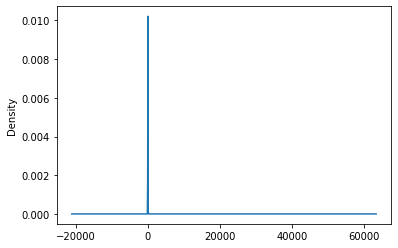

In [113]:
# Visualize the value counts of designation
designation_counts.plot.density()

In [116]:
# Replace the designation values for binning

# Determine which values to replace if counts are less than X
replace_designation = list(designation_counts[designation_counts < 10].index)

# Replace in dataframe
for i in replace_designation:
  rescaledData_pd.designation = rescaledData_pd.designation.replace(i, "Other")

# Check to make sure binning was successful
rescaledData_pd.designation.value_counts()

Other                   82648
N/A                     42304
Reserve                  2704
Reserva                  1755
Estate                   1561
Riserva                   607
Brut                      556
Crianza                   494
Estate Grown              448
Estate Bottled            395
Dry                       364
Old Vine                  330
Gran Reserva              319
Brut Rosé                 227
Bien Nacido Vineyard      195
Extra Dry                 194
Vieilles Vignes           177
Rosé                      171
Late Harvest              161
Unoaked                   156
Barrel Select             145
Grand Reserve             138
Single Vineyard           137
Réserve                   137
Old Vines                 127
Estate Reserve            121
Late Bottled Vintage      118
Classic                   115
Tinto                     112
Vintage                   103
Special Reserve           102
Kosher                    101
Name: designation, dtype: int64

In [129]:
# Look at the province value counts for binning
province_counts = rescaledData_pd.province.value_counts()
province_counts.tail(400)

Pfalz            244
France Other     243
Kremstal         243
Martinborough    236
Dão              219
                ... 
Beni M'Tir         1
Grand Reserve      1
Dolenjska          1
Pafos              1
 dusty even        1
Name: province, Length: 400, dtype: int64

In [134]:
# Replace the province values for binning

# Determine which values to replace if counts are less than X
replace_province = list(province_counts[province_counts < 300].index)

# Replace in dataframe
for i in replace_province:
  rescaledData_pd.province = rescaledData_pd.province.replace(i, "Other")

# Check to make sure binning was successful
rescaledData_pd.province.value_counts()

California              44343
Other                   11427
Washington               9683
Tuscany                  5961
Northern Spain           4823
Mendoza Province         4706
Oregon                   4571
Burgundy                 3340
Veneto                   3103
South Australia          2949
Piedmont                 2908
Bordeaux                 2658
New York                 2413
Sicily & Sardinia        2031
Northeastern Italy       1851
Marlborough              1595
Loire Valley             1391
Alsace                   1359
Catalonia                1331
Southwest France         1318
Central Italy            1257
Rhône Valley             1231
Colchagua Valley         1192
Southern Italy           1167
Champagne                1089
Languedoc-Roussillon     1023
Maipo Valley              888
Douro                     859
Provence                  828
Casablanca Valley         773
Mosel                     760
Central Spain             743
Alentejano                700
Stellenbos

In [140]:
# Look at the region_1 counts for binning
region_counts = rescaledData_pd.region_1.value_counts()
region_counts.tail(1000)

Coteaux d'Aix-en-Provence        85
Langhorne Creek                  84
Gaillac                          83
Chalone                          83
Chianti Rufina                   83
                                 ..
Vino de Calidad de Valtiendas     1
Prince Edward County              1
Vesuvio                           1
Uncut                             1
Del Veneto                        1
Name: region_1, Length: 1000, dtype: int64

In [147]:
# Replace the region values for binning

# Determine which values to replace if counts are less than X
replace_region = list(region_counts[region_counts < 500].index)

# Replace in dataframe
for i in replace_region:
  rescaledData_pd.region_1 = rescaledData_pd.region_1.replace(i, "Other")

# Check to make sure binning was successful
rescaledData_pd.region_1.value_counts()

Other                                  49448
N/A                                    22833
Napa Valley                             6187
Columbia Valley (WA)                    4941
Mendoza                                 3556
Russian River Valley                    3537
California                              3458
Paso Robles                             3039
Willamette Valley                       2085
Rioja                                   1884
Sonoma County                           1852
Toscana                                 1660
Sonoma Coast                            1473
Carneros                                1456
Dry Creek Valley                        1396
Finger Lakes                            1365
Sicilia                                 1364
Santa Barbara County                    1313
Brunello di Montalcino                  1305
Alsace                                  1261
Walla Walla Valley (WA)                 1207
Yakima Valley                           1157
Alexander 

In [150]:
# Look at the variety counts for binning
variety_counts = rescaledData_pd.variety.value_counts()
variety_counts.tail(500)

Trebbiano                  48
Cabernet Merlot            48
Verdicchio                 47
Syrah-Grenache             47
Weissburgunder             46
                           ..
Macabeo-Gewürztraminer      1
Sarba                       1
Pinot Grigio-Chardonnay     1
White Port                  1
Vidadillo                   1
Name: variety, Length: 500, dtype: int64

In [155]:
# Replace the variety values for binning

# Determine which values to replace if counts are less than X
replace_variety = list(variety_counts[variety_counts < 500].index)

# Replace in dataframe
for i in replace_variety:
  rescaledData_pd.variety = rescaledData_pd.variety.replace(i, "Other")

# Check to make sure binning was successful
rescaledData_pd.variety.value_counts()

Other                            17692
Chardonnay                       13773
Pinot Noir                       13622
Cabernet Sauvignon               12663
Red Blend                         9377
Sauvignon Blanc                   6054
Syrah                             5667
Riesling                          5210
Merlot                            4985
Bordeaux-style Red Blend          4545
Zinfandel                         3792
Malbec                            3085
Sangiovese                        2879
White Blend                       2554
Tempranillo                       2525
Rosé                              2461
Shiraz                            1941
Sparkling Blend                   1819
Portuguese Red                    1811
Nebbiolo                          1528
Rhône-style Red Blend             1455
Cabernet Franc                    1310
Corvina, Rondinella, Molinara     1292
Pinot Gris                        1275
Pinot Grigio                      1268
Viognier                 

In [158]:
# Look at the winery counts for binning
winery_counts = rescaledData_pd.winery.value_counts()
winery_counts.tail(1000)

Celler Piñol             1
Chase                    1
La Cruz                  1
Montevannos              1
Mooney Family            1
                        ..
Williams & Heim          1
Vallemon de Sardilici    1
Finca Los Olmos          1
A By Acacia              1
Sombrero                 1
Name: winery, Length: 1000, dtype: int64

In [161]:
# Replace the winery values for binning

# Determine which values to replace if counts are less than X
replace_winery = list(winery_counts[winery_counts < 100].index)

# Replace in dataframe
for i in replace_winery:
  rescaledData_pd.winery = rescaledData_pd.winery.replace(i, "Other")

# Check to make sure binning was successful
rescaledData_pd.winery.value_counts()

Other                    125294
Williams Selyem             371
Testarossa                  274
DFJ Vinhos                  249
Chateau Ste. Michelle       225
                          ...  
Ferrari-Carano              101
Ken Wright                  101
Schug                       101
Maryhill                    101
Chateau St. Jean            100
Name: winery, Length: 89, dtype: int64

### **Encode the categorical values**

In [162]:
# Check the column data types
rescaledData_pd.dtypes

country            object
designation        object
points             object
price              object
province           object
region_1           object
variety            object
winery             object
tokens              int32
filtered_tokens     int32
features           object
dtype: object

In [164]:
# Convert columns to numeric
rescaledData_pd["price","points","filtered_tokens","features"] = rescaledData_pd["price","points","filtered_tokens","features"].apply(pd.to_numeric)
rescaledData_pd.dtypes

KeyError: ignored

In [93]:
# Generate our categorical variable lists
categories = rescaledData_pd.dtypes[rescaledData_pd.dtypes == 'object'].index.tolist()
categories

['country',
 'designation',
 'points',
 'price',
 'province',
 'region_1',
 'variety',
 'winery',
 'words',
 'filtered',
 'hashedValues',
 'features']

In [ ]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(rescaledData_pd[categories]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(categories)
encode_df.head()

In [ ]:
# Merge one-hot encoded features and drop the originals
cleaned_df = rescaledData_pd.merge(encode_df, left_index=True, right_index=True)
cleaned_df = rescaledData_pd.drop(categories,axis=1)
cleaned_df.head()

### **Save the cleaned dataframe as a csv file in GDrive**

Download file and upload to S3 until I can figure out how to connect to PGAdmin

In [37]:
# Convert Spark df to Pandas df 
#cleaned_df = rescaledData_pd.toPandas()

AttributeError: ignored

In [ ]:
# Connect to GDrive
from google.colab import drive
drive.mount('drive')

In [ ]:
# Export dataframe to csv in GDrive
cleaned_df.to_csv('winemag-data_cleaning_inprogress.csv')

# Path = "drive/My Drive/destination folder"
!cp winemag-data_cleaning_inprogress.csv "drive/My Drive/UCB Data Bootcamp/Whats_In_A_Bottle"

### **Export the Dataframe to our Database (connect to pgAdmin)**

In [ ]:
# Connect spark and postgres
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

In [ ]:
# Configure settings for RDS
mode = "overwrite"
jdbc_url="jdbc:postgresql://postgres.cuvwsdzowgas.us-west-1.rds.amazonaws.com:5432/whats-in-a-bottle"
config = {"user":"postgres",
          "password": "bootcamp-whats-in-a-bottle",
          "driver":"org.postgresql.Driver"}

In [ ]:
# Write Dataframe to cleaned data table in RDS

# ***Need to create an empty table in PGAdmin first

rescaledData.write.jdbc(url=jdbc_url, table='cleaned_data', mode=mode, properties=config)